In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from pynq import Overlay, allocate
import xrfclk
import numpy as np
import xrfdc
import os

ERROR: Unknown command: 'dump'


In [3]:
# Functions 
def volts_to_samples(voltage):
    return voltage/(1.2/65536)

def samples_to_voltage(amplitude):
    return amplitude*(1.2/65536)

# Config for signal generation
sample_rate = 153.6e6
tsample = 1/sample_rate
ramp_freq = 8e3
tc = 0.75*(1/ramp_freq)
tsilence = (1/ramp_freq)-tc

vmax = 555e-3
vmax_sample = volts_to_samples(vmax)
vmin = -500e-3
vmin_sample = volts_to_samples(vmin)
samples_ramp = tc*sample_rate
samples_silence = tsilence*sample_rate
step = volts_to_samples(vmax-vmin)/samples_ramp


In [4]:
# Initial configuration
xrfclk.set_all_ref_clks(1228.8)
ol = Overlay("/home/xilinx/jupyter_notebooks/design_1.bit")

rf = ol.usp_rf_data_converter_0
ol.ip_dict

{'usp_rf_data_converter_0': {'fullpath': 'usp_rf_data_converter_0',
  'type': 'xilinx.com:ip:usp_rf_data_converter:2.4',
  'bdtype': None,
  'state': None,
  'addr_range': 262144,
  'phys_addr': 2684354560,
  'mem_id': 's_axi',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_AMS_Factory_Var': '0',
   'C_COMPONENT_NAME': 'design_1_usp_rf_data_converter_0_0',
   'C_High_Speed_ADC': '1',
   'C_IP_Type': '0',
   'C_Axiclk_Freq': '100.0',
   'C_Sysref_Source': '1',
   'C_Converter_Setup': '1',
   'C_ADC_Debug': 'false',
   'C_DAC_Debug': 'false',
   'C_DAC_Output_Current': '0',
   'C_DAC_VOP_Mode': '1',
   'C_DAC_RTS': 'false',
   'C_ADC_RTS': 'false',
   'C_Analog_Detection': '1',
   'C_Calibration_Freeze': 'false',
   'C_Auto_Calibration_Freeze': 'false',
   'C_Calibration_Time': '10',
   'C_DAC_NCO_RTS': 'false',
   'C_DAC_VOP_RTS': 'false',
   'C_ADC_NCO_RTS': 'false',
   'C_ADC_DSA_RTS': 'false',
   'C_RESERVED_2': 'false',
   'C_ADC0_Enable': '1',
   'C_

In [5]:
# Reservamos memoria para el buffer de entrada
dma_frame = ol.dma_frame
buffer_size = int(2**11)
num_bytes = int(buffer_size*2)
print(f"buffer size = {buffer_size}\nnbytes = {num_bytes}")
buffer = allocate(shape=(buffer_size,), dtype=np.int16)
frame = allocate(shape=(2**20,), dtype=np.int16)

buffer size = 2048
nbytes = 4096


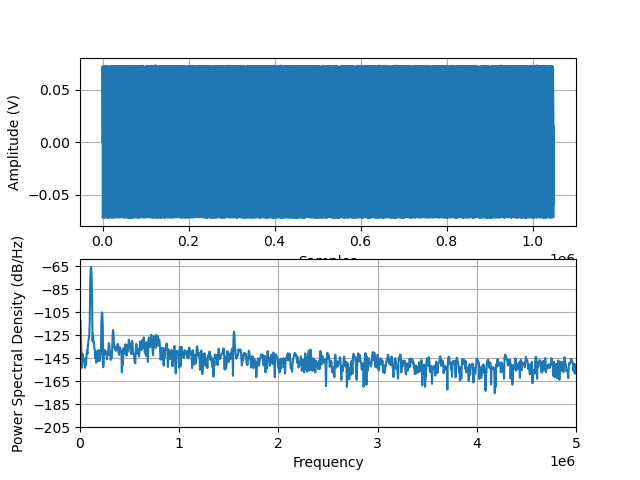

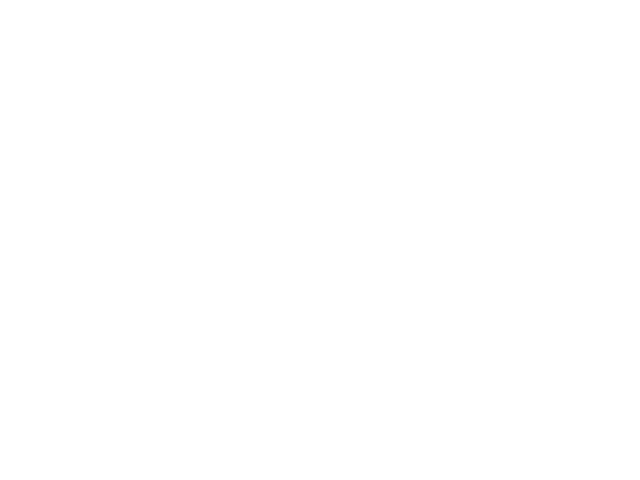

In [6]:
# Adquirimos
for i in range(0, int(len(frame)/len(buffer))):
    dma_frame.recvchannel.transfer(buffer)
    dma_frame.recvchannel.wait()
    frame[i*len(buffer):(i+1)*len(buffer)] = buffer  

# Plots
plt.clf()
plt.figure()
plt.subplot(2,1,1)
plt.plot(samples_to_voltage(frame))
plt.xlabel("Samples")
plt.ylabel("Amplitude (V)")
plt.grid()
plt.subplot(2,1,2)
plt.psd(samples_to_voltage(frame[0:32768]), NFFT=32768, Fs=sample_rate, window=np.blackman(32768))
plt.xlim([0,5e6])
plt.show()

In [32]:
del buffer, frame